In [1]:
experiment_name = "baseline.classifier.cnn_4_retinas.sig56_vs_bg"


In [2]:
%load_ext autoreload
%autoreload 2
%env THEANO_FLAGS="device=gpu3"

import sys,os
sys.path.append("..")


env: THEANO_FLAGS="device=gpu3"


In [3]:
#import theano stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## Preprocess/Load data

In [4]:
from config import from_data
data_path_sig = from_data("sig56/")
data_path_bg_up = from_data("bg_up/")
data_path_bg_down = from_data("bg_down/")
metadata_path = from_data("k0s_event_identification")


generate_metadata = not os.path.exists(metadata_path)
if generate_metadata:
    print "Metadata does not exist. This run might be MUCH longer due to preprocessing the data."

In [5]:
from lib.retina_compiled import retina_view, retinize_events
import random
get_random_ids = lambda path,k: random.sample(set(map(lambda s: s.split('.')[0],os.listdir(path))), k)



retina_images_path = os.path.join(metadata_path,"retina_images.npy")
answers_path = os.path.join(metadata_path,"sig_or_bg.npy")

if generate_metadata:
    


    param_df = pd.DataFrame.from_csv(from_data("retinas/sig_vs_bg_0.csv"))
    retinas = [retina_view(*params) for params in param_df.values]


    
    sample_names = ["signal","bg_up","bg_down"]

    sample_sizes = [10000,5000,5000]

    y = map(np.repeat, sample_names,sample_sizes)
    y = np.concatenate(y)

    data_paths = [data_path_sig,data_path_bg_up,data_path_bg_down]

    random.seed(7331)
    #event ids : "{runnumber}_{eventnumber}"
    data_runids = map(get_random_ids,data_paths,sample_sizes)

    data_X = [
        retinize_events(ids_i,path_i,retina_views=retinas,
                                 max_hits_block=15000,report_rate=100)
        for ids_i,path_i in zip(data_runids,data_paths)
    ]

    X = np.concatenate(data_X)


    y = np.concatenate(map(np.repeat, sample_names,sample_sizes))
    
    
    os.mkdir(metadata_path)
    np.save(retina_images_path,X)
    np.save(answers_path, y)
    
    generate_metadata = False
else:
    #load metadata
    X = np.load(retina_images_path)
    y = np.load(answers_path)

Using gpu device 3: Tesla K40m (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)


In [6]:
X = X.reshape([len(X),-1,32,32])

X = X.astype("float32")
y = (y=="signal").astype('int32')

In [7]:
from sklearn.cross_validation import train_test_split
Xtr, Xts, Ytr,Yts = train_test_split(X,y,test_size=0.25,random_state=1337)

print Ytr.shape,Yts.shape

(15000,) (5000,)


# define NN

In [8]:
import lasagne
import theano
import theano.tensor as T

floatX = theano.config.floatX


In [9]:
input_dim = (None,)+X.shape[1:]

retina_dim = (None,1) + X.shape[2:]

retina_images = T.tensor4("input_images","floatX")

any_interesting_decays = T.ivector("event_has_k0s")

In [10]:
concatenated_retinas = retina_images.reshape([retina_images.shape[0],1,-1,retina_images.shape[-1]])

concatenated_dim = (None,1,np.prod(X.shape[1:-1]),X.shape[-1])

In [12]:
from lasagne.layers import InputLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import DenseLayer, DropoutLayer
from lasagne.layers import batch_norm

#nn where each retina is processed with a separate CNN

net = {}

net['input'] = InputLayer(concatenated_dim,input_var=concatenated_retinas)
net['conv1_1'] = ConvLayer(
            net['input'], 256, 5, pad=1, flip_filters=False)
net['pool1'] = PoolLayer(net['conv1_1'], 3)
net['conv2_1'] = ConvLayer(
            net['pool1'], 256, 5, pad=1, flip_filters=False)

net['conv2_bn'] = batch_norm(net['conv2_1'])

net['pool2'] = PoolLayer(net['conv2_bn'], 3)
    
net['fc0'] = DenseLayer(net["pool2"], num_units=2048)
net['fc0_dropout'] = DropoutLayer(net['fc0'], p=0.5)
net['fc1'] = DenseLayer(net["fc0_dropout"], num_units=2048)

net['out'] = DenseLayer(net['fc1'], num_units=2, 
                        nonlinearity=lasagne.nonlinearities.softmax)



In [13]:
weights = lasagne.layers.get_all_params(net["out"],trainable=True)
weights

[W, b, W, beta, gamma, W, b, W, b, W, b]

# train updates

In [14]:
train_prediction = lasagne.layers.get_output(net["out"])
train_loss_ce = lasagne.objectives.categorical_crossentropy(train_prediction,any_interesting_decays).mean()
train_accuracy = lasagne.objectives.categorical_accuracy(train_prediction,any_interesting_decays).mean()
updates = lasagne.updates.rmsprop(train_loss_ce,weights,learning_rate=0.001) 
#ik that lr does not matter. I just dont want an explosion.

In [15]:
train_fun = theano.function([retina_images,any_interesting_decays],[train_loss_ce,train_accuracy,train_prediction[:,1]], updates=updates)

# evaluation

In [16]:
prediction = lasagne.layers.get_output(net["out"],deterministic=True)
loss_ce = lasagne.objectives.categorical_crossentropy(prediction,any_interesting_decays).mean()
accuracy = lasagne.objectives.categorical_accuracy(prediction,any_interesting_decays).mean()

In [17]:
eval_fun = theano.function([retina_images,any_interesting_decays], [loss_ce,accuracy,prediction[:,1]])
predict_fun = theano.function([retina_images],prediction)

# main loop
* almost copies the layout of lasagne basic training 

In [18]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False,crop_at=None):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if crop_at == start_idx:
            break
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        


In [19]:
from collections import defaultdict
from sklearn.metrics import roc_auc_score
metrics = defaultdict(dict)

import time
num_epochs = 50
batch_size = 50

# We iterate over epochs:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    y_pred_batches = []
    y_ref_batches = []
    for batch in iterate_minibatches(Xtr, Ytr, batch_size, shuffle=True):
        batch_ce,batch_acc,pred_batch= train_fun(*batch)
        train_err +=batch_ce
        train_acc +=batch_acc
        train_batches += 1
        y_pred_batches.append(pred_batch)
        y_ref_batches.append(batch[1])
        
    y_pred = np.concatenate(y_pred_batches)
    y_ref = np.concatenate(y_ref_batches)
    train_auc = roc_auc_score(y_ref,y_pred)

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    y_pred_batches = []
    y_ref_batches = []
    for batch in iterate_minibatches(Xts, Yts, batch_size, shuffle=False):
        err, acc,pred_batch = eval_fun(*batch)
        val_err += err
        val_acc += acc
        val_batches += 1
        y_pred_batches.append(pred_batch)
        y_ref_batches.append(batch[1])

    y_pred = np.concatenate(y_pred_batches)
    y_ref = np.concatenate(y_ref_batches)
    val_auc = roc_auc_score(y_ref,y_pred)

    metrics["acc_train"][epoch] = train_acc/train_batches
    metrics["auc_train"][epoch] = train_auc
    metrics["acc_test"][epoch] = val_acc/val_batches
    metrics["auc_test"][epoch] = val_auc
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches*100))
    print("  training ROC AUC:\t\t{:.3f} %".format(
        train_auc*100))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.3f} %".format(
        val_acc / val_batches*100))
    print("  validation ROC AUC:\t\t{:.3f} %".format(
        val_auc*100))



Epoch 1 of 50 took 89.397s
  training loss:		1.168029
  training accuracy:		60.87 %
  training ROC AUC:		64.837 %
  validation loss:		0.508441
  validation accuracy:		81.160 %
  validation ROC AUC:		89.652 %
Epoch 2 of 50 took 89.223s
  training loss:		0.490669
  training accuracy:		76.91 %
  training ROC AUC:		84.565 %
  validation loss:		0.443510
  validation accuracy:		82.480 %
  validation ROC AUC:		93.424 %
Epoch 3 of 50 took 89.668s
  training loss:		0.429964
  training accuracy:		80.39 %
  training ROC AUC:		88.318 %
  validation loss:		0.496859
  validation accuracy:		85.640 %
  validation ROC AUC:		93.828 %
Epoch 4 of 50 took 93.757s
  training loss:		0.394594
  training accuracy:		82.08 %
  training ROC AUC:		90.218 %
  validation loss:		0.421310
  validation accuracy:		80.920 %
  validation ROC AUC:		93.708 %
Epoch 5 of 50 took 92.263s
  training loss:		0.370364
  training accuracy:		83.05 %
  training ROC AUC:		91.371 %
  validation loss:		0.364636
  validation accuracy:		8

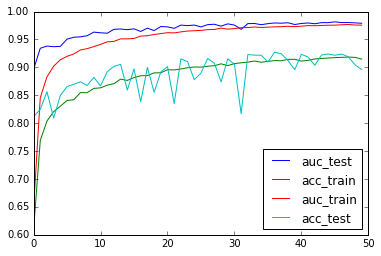

In [22]:
for metric_name in metrics:
    
    plt.plot(*zip(*sorted(metrics[metric_name].items())),label = metric_name)
plt.legend(loc='best')

# Evaluation

In [ ]:
val_err = 0
val_acc = 0
val_batches = 0
y_pred_batches = []
y_ref_batches = []

for batch in iterate_minibatches(Xts, Yts, batch_size, shuffle=False):
    err, acc,pred_batch = eval_fun(*batch)
    val_err += err
    val_acc += acc
    val_batches += 1
    y_pred_batches.append(pred_batch)
    y_ref_batches.append(batch[1])

y_pred = np.concatenate(y_pred_batches)
y_ref = np.concatenate(y_ref_batches)
val_auc = roc_auc_score(y_ref,y_pred)

print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
print("  validation accuracy:\t\t{:.3f} %".format(
    val_acc*100 / val_batches))
print("  validation ROC AUC:\t\t{:.3f} %".format(
    val_auc*100))
